# Test d-wave sampler on CPU: the PCI use case

The Phyical Cell Identifier (PCI) problem is a scheduling problem with great relevance in the telecommunication business. At each node (antenna) a unique identifier must be assigned to optimised the communication between the (mobile) end-user and the network avoinding "conflicts" and "confusion". In a dedicated lesson TIM enginners will explain the details of the problem, the mathetematical formulation and its translation into a QUBO format for resolution with "Quantum Algorithm". Here, we only need to know that the optimisation problem can be recasted as a graph coloring or more generally a max-k-cut problem.  

In [1]:
!pip install dwave-ocean-sdk
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
import dimod
import itertools
import neal
import numpy.matlib
import time
#from dwave_qbsolv import QBSolv
# for new sampler
import hybrid
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import AutoEmbeddingComposite

Let's load a small PCI data set with 67 nodes. 

In [80]:
filename = 'pci_data/255_Q1_Q2_C_b.ncolors_24.npz' # small problem 
data = np.load(filename)
Q1 = data['Q1']
Q2 = data['Q2']
C = data['C']
b = data['b']
# Make complete QUBO problem
P = 2#4 # Penalty weight for constraints equations
# Build QUBO matrix
Q = Q1+P*Q2

The PCI assignment has been formulated as graph coloring problem with 21 colors. We produced and loaded two QUBO matrices, Q1 and Q2. The first implements the adjacency constrains, the penalties due to the assigment of the same PCI. The second, Q2, is a solvability condition favoring a solution where al nodes are assigned one and only one PCI. Let's have a look at this matrices. 

Text(0, 0.5, 'qubo variable #')

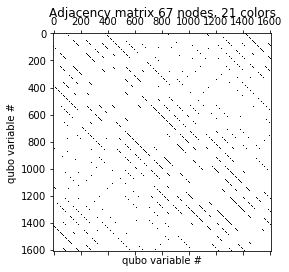

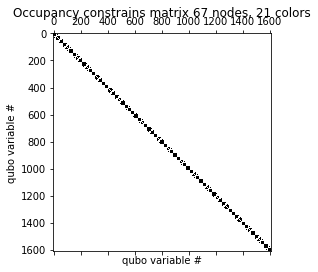

In [71]:
# Plot matrices 
plt.figure(0)
plt.title("Adjacency matrix 67 nodes, 21 colors")
plt.spy(Q1)
plt.xlabel("qubo variable #")
plt.ylabel("qubo variable #")
#
plt.figure(1)
plt.title("Occupancy constrains matrix 67 nodes, 21 colors")
plt.spy(Q2)
plt.xlabel("qubo variable #")
plt.ylabel("qubo variable #")

Now let's start with my favourite solver: QBsolv. It is now "deprecated" but it still performs well!

In [83]:
# ------------------- Solve problem with QBSolv --------------------------------      
#QBSolv_iter = 50#300
#sampler = neal.SimulatedAnnealingSampler()
#time_start=time.time()
#QBSolv_response = QBSolv().sample_qubo(Q,num_repeats=QBSolv_iter)  # solving with default tabu search
#time_stop=time.time()
#chosenSample = QBSolv_response.samples()[0]
#xArray = []
#for i in chosenSample:
#    xArray.append(chosenSample[i])
#x = np.asarray(xArray)
# check solution constraints
#solution_ok = np.prod(C@x == b)
#CPUtime_QBSolv = time_stop -time_start
#print('Valid solution? {}'.format(solution_ok))
#print('CPU time [s] QBSolv: {}'.format(CPUtime_QBSolv))
#print('Minimum energy QBSolv: {}'.format(QBSolv_response.data_vectors['energy'][0]))
#print('Residual cost: {}'.format(np.transpose(x)@Q1@x))

Valid solution? 0
CPU time [s] QBSolv: 10.329655408859253
Minimum energy QBSolv: -532.0
Residual cost: 0.0


In [92]:
# ------------------------- 'Simulated Annealing ------------------------------  
model = dimod.BinaryQuadraticModel.from_numpy_matrix(Q)
sampler = neal.SimulatedAnnealingSampler()
time_start=time.time()
response = sampler.sample(model, num_reads=300)
time_stop=time.time()
minIndex = np.where(response.data_vectors['energy'] == np.amin(response.data_vectors['energy']))
# taking only the first one, if there are more than one minimum energies
chosenIndex = int(minIndex[0][0])
chosenEnergy = response.data_vectors['energy'][chosenIndex]
chosenSample = response.samples()[0]
xArray = []
for i in chosenSample:
    xArray.append(chosenSample[i])
x = np.asarray(xArray)
# check solution constraints
solution_ok = np.prod(C@x == b)
CPUtime_Neal = time_stop -time_start
print('Valid solution? {}'.format(solution_ok))
print('CPU time [s] Neal: {}'.format(CPUtime_Neal))
print('Minimum energy Neal: {}'.format(chosenEnergy))
print('Residual cost: {}'.format(np.transpose(x)@Q1@x))

Valid solution? 0
CPU time [s] Neal: 13.74678897857666
Minimum energy Neal: -504.0
Residual cost: 0.0


We now introduce a hybrid model: an asynchronous decomposition samplers for quadratic unconstrained binary optimization (QUBO) problems. The basic components—building blocks—you use are based on the Runnable class: decomposers, samplers, and composers. 
We combine several sampler running in parallel, decompose into smaller subproblems and recompose to find the best solution. We can also run subproblems with remote QPU.
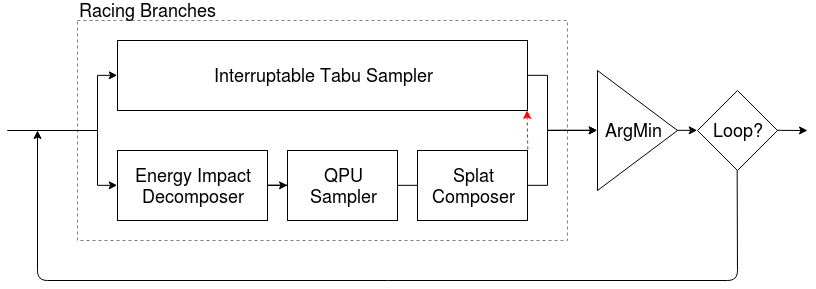. 

In [89]:
# Solve with hybrid module
# ------------- 'Hybrid-SA-TSearch' --------------------------------------------
model = dimod.BinaryQuadraticModel.from_numpy_matrix(Q)
# construct a workflow that races Simulated Annealing against SA/Tabu on a subproblem
iteration = hybrid.Race(hybrid.SimulatedAnnealingProblemSampler(),
hybrid.EnergyImpactDecomposer(size=50)
| hybrid.RacingBranches(
hybrid.SimulatedAnnealingSubproblemSampler(num_sweeps=1000),
hybrid.TabuSubproblemSampler(tenure=20,timeout=10))
| hybrid.ArgMin('subsamples.first.energy')
| hybrid.SplatComposer()
) | hybrid.ArgMin('samples.first.energy')
main = hybrid.Loop(iteration, max_iter=3, convergence=3)
# run the workflow
time_start=time.time()
init_state = hybrid.State.from_sample(hybrid.utils.min_sample(model), model)
Hybrid_SA_TS_response = main.run(init_state).result()
time_stop=time.time()
chosenSample = Hybrid_SA_TS_response.samples.first.sample
xArray = []
for i in chosenSample:
    xArray.append(chosenSample[i])
x = np.asarray(xArray)
# check solution constraints
solution_ok = np.prod(C@x == b)
CPUtime_Hybrid_SA_TS = time_stop -time_start
print('Valid solution? {}'.format(solution_ok))
print('CPU time [s] Hybrid_SA_TS: {}'.format(CPUtime_Hybrid_SA_TS))
print('Minimum energy Hybrid_SA_TS: {}'.format(Hybrid_SA_TS_response.samples.first.energy))
print('Residual cost: {}'.format(np.transpose(x)@Q1@x))

Valid solution? 0
CPU time [s] Hybrid_SA_TS: 9.303130626678467
Minimum energy Hybrid_SA_TS: -460.0
Residual cost: 0.0


In the next example we try to reproduce QBsolv-like algorithm which uses an energy-based decomposition and a local Tabu search on subproblems. 

In [91]:
# ------------------------- 'Hybrid-QBSolv-like' ------------------------------     
model = dimod.BinaryQuadraticModel.from_numpy_matrix(Q)
# define the QBSolv-like workflow
iteration = hybrid.Race(hybrid.InterruptableTabuSampler(),
hybrid.EnergyImpactDecomposer(size=50, rolling=True, rolling_history=0.15)
#| hybrid.QPUSubproblemAutoEmbeddingSampler()
| hybrid.TabuSubproblemSampler()#(timeout=10)
| hybrid.SplatComposer()
) | hybrid.ArgMin() | hybrid.TrackMin(output=True)
main = hybrid.Loop(iteration, max_iter=50, convergence=3)
# run the workflow
time_start=time.time()
init_state = hybrid.State.from_sample(hybrid.min_sample(model), model)
Hybrid_QBSolv_like_response = main.run(init_state).result()
time_stop=time.time()
CPUtime_Hybrid_QBSolv_like = time_stop -time_start
chosenSample = Hybrid_QBSolv_like_response.samples.first.sample
xArray = []
for i in chosenSample:
    xArray.append(chosenSample[i])
x = np.asarray(xArray)
# check solution constraints
solution_ok = np.prod(C@x == b)
print('Valid solution? {}'.format(solution_ok))
print('CPU time [s] Hybrid_QBSolv_like: {}'.format(CPUtime_Hybrid_QBSolv_like))
print('Minimum energy Hybrid_QBSolv_like: {}'.format(Hybrid_QBSolv_like_response.samples.first.energy))
print('Residual cost: {}'.format(np.transpose(x)@Q1@x))

Valid solution? 1
CPU time [s] Hybrid_QBSolv_like: 25.263331651687622
Minimum energy Hybrid_QBSolv_like: -536.0
Residual cost: 0.0


We now try the "reference" hybrid solver Kerberos which runs 3 sampling branches in parallel. In each iteration,
best results from tabu search and simulated annealing are combined with best
results from QPU sampling a subproblem.

In [82]:
from hybrid.reference.kerberos import KerberosSampler
model = dimod.BinaryQuadraticModel.from_numpy_matrix(Q)
response_Kerberos = KerberosSampler().sample(model, max_iter=10, convergence=3)
time_stop=time.time()    
CPUtime_Kerberos = time_stop -time_start
chosenSample = response_Kerberos.samples()[0]
xArray = []
for i in chosenSample:
    xArray.append(chosenSample[i])
x = np.asarray(xArray)
# check solution constraints
solution_ok = np.prod(C@x == b)
print('Valid solution? {}'.format(solution_ok))
print('CPU time [s] Kerberos: {}'.format(CPUtime_Kerberos))
print('Minimum energy Kerberos: {}'.format(response_Kerberos.first.energy))
print('Residual cost: {}'.format(np.transpose(x)@Q1@x))

Valid solution? 1
CPU time [s] Kerberos: 157.23249864578247
Minimum energy Kerberos: -536.0
Residual cost: 0.0
